# Analysis of Superstore Sales Data

**Author:** M.Umer Mehmood

**Email:** umermehmood5149@gmail.com

**Date:** 27/07/25

**Dataset:** [https://www.kaggle.com/datasets/vivek468/superstore-dataset-final]

# Import Libraries

In [ ]:
# general libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
                             classification_report)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import learning_curve

# Statistical libraries
from scipy import stats
from scipy.stats import ttest_ind

# Model interpretability
import shap

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("=" * 80)
print("ENVIRONMENT & REPRODUCIBILITY INFORMATION")
print("=" * 80)
print(f"Python Libraries:")
print(f"  - pandas: {pd.__version__}")
print(f"  - numpy: {np.__version__}")
print(f"  - scikit-learn: {__import__('sklearn').__version__}")
print(f"  - seaborn: {sns.__version__}")
print(f"  - matplotlib: {__import__('matplotlib').__version__}")
print(f"  - shap: {shap.__version__}")
print(f"\nRandom Seed: {RANDOM_STATE}")
print("=" * 80)


ENVIRONMENT & REPRODUCIBILITY INFORMATION
Python Libraries:
  - pandas: 2.2.2
  - numpy: 2.0.2
  - scikit-learn: 1.6.1
  - seaborn: 0.13.2
  - matplotlib: 3.10.0
  - shap: 0.49.1

Random Seed: 42


# Loading Dataset(Application Record)

In [ ]:
df_superstore_data = pd.read_csv("/content/Sample - Superstore.csv", encoding='latin1')

print(df_superstore_data.head())

   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       3  CA-2016-138688   6/12/2016   6/16/2016    Second Class    DV-13045   
3       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
4       5  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   

     Customer Name    Segment        Country             City       State  \
0      Claire Gute   Consumer  United States        Henderson    Kentucky   
1      Claire Gute   Consumer  United States        Henderson    Kentucky   
2  Darrin Van Huff  Corporate  United States      Los Angeles  California   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   

   Postal Code Region       Product ID         Cat

# Getting know about the dataset(Application Record)

In [ ]:
# checking shape of the dataset (application_record)

print('The number of rows in Application Record dataset is', df_superstore_data.shape[0] , '\n')

print('The number of columns in Application Record dataset is', df_superstore_data.shape[1])


The number of rows in Application Record dataset is 9994 

The number of columns in Application Record dataset is 21


# Data Cleaning & Preprocessing Documentation

This section explicitly documents all data cleaning steps performed on the dataset for reproducibility.


In [ ]:
# Step 1: Check for and handle missing values
print("STEP 1: MISSING VALUES ANALYSIS")
print("=" * 60)

missing_values = df_superstore_data.isnull().sum()
missing_percent = (df_superstore_data.isnull().sum() / len(df_superstore_data)) * 100

missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing Count': missing_values.values,
    'Percentage': missing_percent.values
})

print(missing_df[missing_df['Missing Count'] > 0])

if missing_df['Missing Count'].sum() == 0:
    print("✓ No missing values detected in the dataset")
else:
    print(f"\nTotal missing values: {missing_df['Missing Count'].sum()}")

print("\n" + "=" * 60)


STEP 1: MISSING VALUES ANALYSIS
Empty DataFrame
Columns: [Column, Missing Count, Percentage]
Index: []
✓ No missing values detected in the dataset



In [ ]:
# Step 2: Check and handle duplicates
print("STEP 2: DUPLICATE ANALYSIS")
print("=" * 60)

duplicate_count = df_superstore_data.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# Check Order ID duplicates (expected behavior - multiple items per order)
order_duplicates = df_superstore_data['Order ID'].duplicated().sum()
print(f"Duplicate Order IDs: {order_duplicates}")
print("Note: Multiple Order IDs are expected as orders can contain multiple items")

# Check for complete row duplicates
complete_duplicates = df_superstore_data.duplicated(keep=False).sum()
if complete_duplicates > 0:
    print(f"✗ Found {complete_duplicates} complete duplicate rows - removing...")
    df_superstore_data = df_superstore_data.drop_duplicates()
else:
    print("✓ No complete duplicate rows found")

print(f"\nFinal dataset shape: {df_superstore_data.shape}")
print("=" * 60)


STEP 2: DUPLICATE ANALYSIS
Number of duplicate rows: 0
Duplicate Order IDs: 4985
Note: Multiple Order IDs are expected as orders can contain multiple items
✓ No complete duplicate rows found

Final dataset shape: (9994, 21)


In [ ]:
# Step 3: Data type conversions
print("STEP 3: DATA TYPE CONVERSIONS")
print("=" * 60)

# Convert date columns to datetime
df_superstore_data['Order Date'] = pd.to_datetime(df_superstore_data['Order Date'])
df_superstore_data['Ship Date'] = pd.to_datetime(df_superstore_data['Ship Date'])
print("✓ Converted 'Order Date' and 'Ship Date' to datetime format")

# Display data types
print("\nData Types Summary:")
print(df_superstore_data.dtypes.value_counts())

print("\nNumerical Columns:", df_superstore_data.select_dtypes(include=[np.number]).columns.tolist())
print("Categorical Columns:", df_superstore_data.select_dtypes(include=['object']).columns.tolist())
print("=" * 60)


STEP 3: DATA TYPE CONVERSIONS
✓ Converted 'Order Date' and 'Ship Date' to datetime format

Data Types Summary:
object            13
int64              3
float64            3
datetime64[ns]     2
Name: count, dtype: int64

Numerical Columns: ['Row ID', 'Postal Code', 'Sales', 'Quantity', 'Discount', 'Profit']
Categorical Columns: ['Order ID', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name']


STEP 4: OUTLIER DETECTION
Sales:
  Range: [0.44, 22638.48]
  IQR Bounds: [-271.71, 498.93]
  Outliers: 1167 (11.68%)


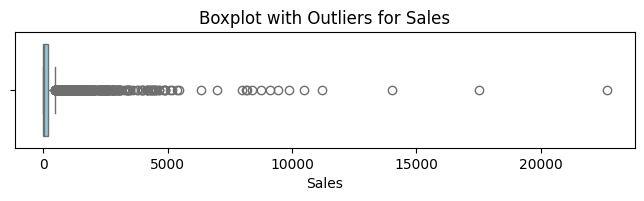

Quantity:
  Range: [1.00, 14.00]
  IQR Bounds: [-2.50, 9.50]
  Outliers: 170 (1.70%)


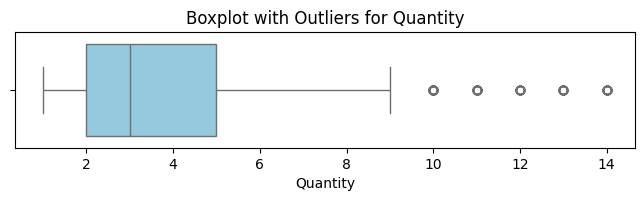

Discount:
  Range: [0.00, 0.80]
  IQR Bounds: [-0.30, 0.50]
  Outliers: 856 (8.57%)


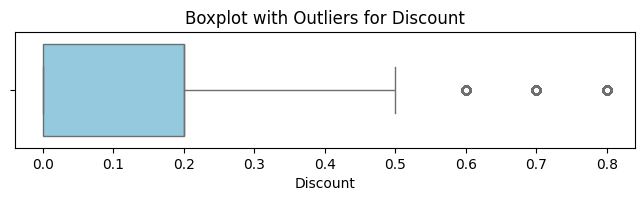

Profit:
  Range: [-6599.98, 8399.98]
  IQR Bounds: [-39.72, 70.82]
  Outliers: 1881 (18.82%)


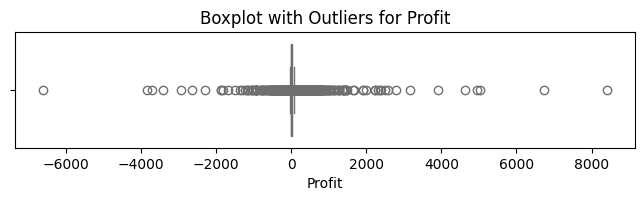


Note: Outliers are retained as they may represent legitimate business cases
(e.g., high-value sales, bulk orders, or loss-making products)


In [ ]:
# Step 4: Outlier Detection (IQR Method)
print("STEP 4: OUTLIER DETECTION")
print("=" * 60)

numerical_cols = ['Sales', 'Quantity', 'Discount', 'Profit']

for col in numerical_cols:
    Q1 = df_superstore_data[col].quantile(0.25)
    Q3 = df_superstore_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_superstore_data[(df_superstore_data[col] < lower_bound) | (df_superstore_data[col] > upper_bound)]
    outlier_percentage = (len(outliers) / len(df_superstore_data)) * 100

    print(f"{col}:")
    print(f"  Range: [{df_superstore_data[col].min():.2f}, {df_superstore_data[col].max():.2f}]")
    print(f"  IQR Bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"  Outliers: {len(outliers)} ({outlier_percentage:.2f}%)")

    # Plotting each numerical column with outliers
    plt.figure(figsize=(8, 1.5))
    sns.boxplot(x=df_superstore_data[col], color="skyblue")
    plt.title(f"Boxplot with Outliers for {col}")
    plt.xlabel(col)
    plt.show()

print("\nNote: Outliers are retained as they may represent legitimate business cases")
print("(e.g., high-value sales, bulk orders, or loss-making products)")
print("=" * 60)

# Feature Engineering Documentation

This section documents how features are created and encoded for machine learning models.


In [ ]:
# Feature Engineering: Creating derived features
print("FEATURE ENGINEERING")
print("=" * 80)

# 1. Create target variable for classification
df_superstore_data['Profitable'] = (df_superstore_data['Profit'] > 0).astype(int)
print("✓ Created binary target: 'Profitable' (1 = Profit > 0, 0 = Loss/Break-even)")

# 2. Extract time-based features
df_superstore_data['Year'] = df_superstore_data['Order Date'].dt.year
df_superstore_data['Month'] = df_superstore_data['Order Date'].dt.month
df_superstore_data['Quarter'] = df_superstore_data['Order Date'].dt.quarter
df_superstore_data['DayOfWeek'] = df_superstore_data['Order Date'].dt.dayofweek
df_superstore_data['Month-Year'] = df_superstore_data['Order Date'].dt.to_period('M').astype(str)
print("✓ Created time-based features: Year, Month, Quarter, DayOfWeek, Month-Year")

# 3. Calculate profit margin
df_superstore_data['Profit_Margin'] = (df_superstore_data['Profit'] / df_superstore_data['Sales']) * 100
df_superstore_data['Profit_Margin'] = df_superstore_data['Profit_Margin'].replace([np.inf, -np.inf], 0)
print("✓ Created 'Profit_Margin' = (Profit / Sales) × 100")

# 4. Create discount categories
df_superstore_data['Discount_Category'] = pd.cut(df_superstore_data['Discount'],
                                   bins=[-0.01, 0, 0.2, 0.4, 1.0],
                                   labels=['No Discount', 'Low', 'Medium', 'High'])
print("✓ Created 'Discount_Category' with bins: No Discount, Low (0-20%), Medium (20-40%), High (>40%)")

print(f"\nTotal features after engineering: {len(df_superstore_data.columns)}")
print(f"New features created: Profitable, Year, Month, Quarter, DayOfWeek, Month-Year, Profit_Margin, Discount_Category")
print("=" * 80)


FEATURE ENGINEERING
✓ Created binary target: 'Profitable' (1 = Profit > 0, 0 = Loss/Break-even)
✓ Created time-based features: Year, Month, Quarter, DayOfWeek, Month-Year
✓ Created 'Profit_Margin' = (Profit / Sales) × 100
✓ Created 'Discount_Category' with bins: No Discount, Low (0-20%), Medium (20-40%), High (>40%)

Total features after engineering: 29
New features created: Profitable, Year, Month, Quarter, DayOfWeek, Month-Year, Profit_Margin, Discount_Category


In [ ]:
# Categorical Encoding Documentation
print("CATEGORICAL ENCODING")
print("=" * 80)

categorical_features = ['Category', 'Segment', 'Region', 'Ship Mode']

print("Encoding Method: One-Hot Encoding (pd.get_dummies)")
print("\nCategorical features to be encoded:")
for feat in categorical_features:
    unique_values = df_superstore_data[feat].nunique()
    print(f"  - {feat}: {unique_values} unique values → {df_superstore_data[feat].unique().tolist()}")

print("\nEncoding will be applied during model training using pd.get_dummies()")
print("drop_first=True will be used to avoid multicollinearity")
print("=" * 80)


CATEGORICAL ENCODING
Encoding Method: One-Hot Encoding (pd.get_dummies)

Categorical features to be encoded:
  - Category: 3 unique values → ['Furniture', 'Office Supplies', 'Technology']
  - Segment: 3 unique values → ['Consumer', 'Corporate', 'Home Office']
  - Region: 4 unique values → ['South', 'West', 'Central', 'East']
  - Ship Mode: 4 unique values → ['Second Class', 'Standard Class', 'First Class', 'Same Day']

Encoding will be applied during model training using pd.get_dummies()
drop_first=True will be used to avoid multicollinearity


In [ ]:
# Enhanced Statistical Summary
print("ENHANCED STATISTICAL SUMMARY")
print("=" * 80)

# Detailed statistics for numerical columns
numerical_stats = df_superstore_data[['Sales', 'Quantity', 'Discount', 'Profit']].describe()
print("\nDescriptive Statistics:")
print(numerical_stats)

# Additional statistics
print("\nAdditional Metrics:")
for col in ['Sales', 'Quantity', 'Discount', 'Profit']:
    print(f"\n{col}:")
    print(f"  Median: {df_superstore_data[col].median():.2f}")
    print(f"  Skewness: {df_superstore_data[col].skew():.3f}")
    print(f"  Kurtosis: {df_superstore_data[col].kurtosis():.3f}")

print("=" * 80)


ENHANCED STATISTICAL SUMMARY

Descriptive Statistics:
              Sales     Quantity     Discount       Profit
count   9994.000000  9994.000000  9994.000000  9994.000000
mean     229.858001     3.789574     0.156203    28.656896
std      623.245101     2.225110     0.206452   234.260108
min        0.444000     1.000000     0.000000 -6599.978000
25%       17.280000     2.000000     0.000000     1.728750
50%       54.490000     3.000000     0.200000     8.666500
75%      209.940000     5.000000     0.200000    29.364000
max    22638.480000    14.000000     0.800000  8399.976000

Additional Metrics:

Sales:
  Median: 54.49
  Skewness: 12.973
  Kurtosis: 305.312

Quantity:
  Median: 3.00
  Skewness: 1.279
  Kurtosis: 1.992

Discount:
  Median: 0.20
  Skewness: 1.684
  Kurtosis: 2.410

Profit:
  Median: 8.67
  Skewness: 7.561
  Kurtosis: 397.189


CORRELATION ANALYSIS

Correlation with Profit:
Profit           1.000000
Sales            0.479064
Profit_Margin    0.223732
Quantity         0.066253
Discount        -0.219487
Name: Profit, dtype: float64


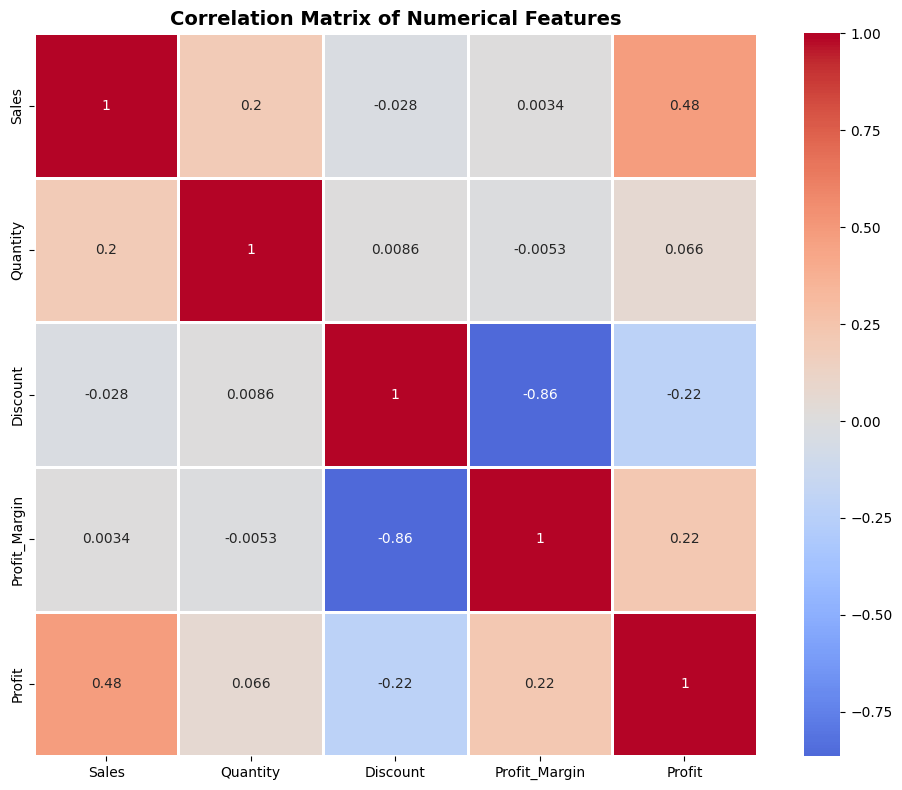


Key Insights:
  - Strongest positive correlation with Profit: Sales (0.479)
  - Strongest negative correlation with Profit: Discount (-0.219)


In [ ]:
# Correlation Analysis
print("CORRELATION ANALYSIS")
print("=" * 80)

# Calculate correlations with Profit
numerical_cols = ['Sales', 'Quantity', 'Discount', 'Profit_Margin']
correlations = df_superstore_data[numerical_cols + ['Profit']].corr()['Profit'].sort_values(ascending=False)

print("\nCorrelation with Profit:")
print(correlations)

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df_superstore_data[numerical_cols + ['Profit']].corr(), annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1)
plt.title('Correlation Matrix of Numerical Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nKey Insights:")
print(f"  - Strongest positive correlation with Profit: {correlations.index[1]} ({correlations.iloc[1]:.3f})")
if correlations.min() < 0:
    min_corr_idx = correlations.idxmin()
    print(f"  - Strongest negative correlation with Profit: {min_corr_idx} ({correlations[min_corr_idx]:.3f})")
print("=" * 80)


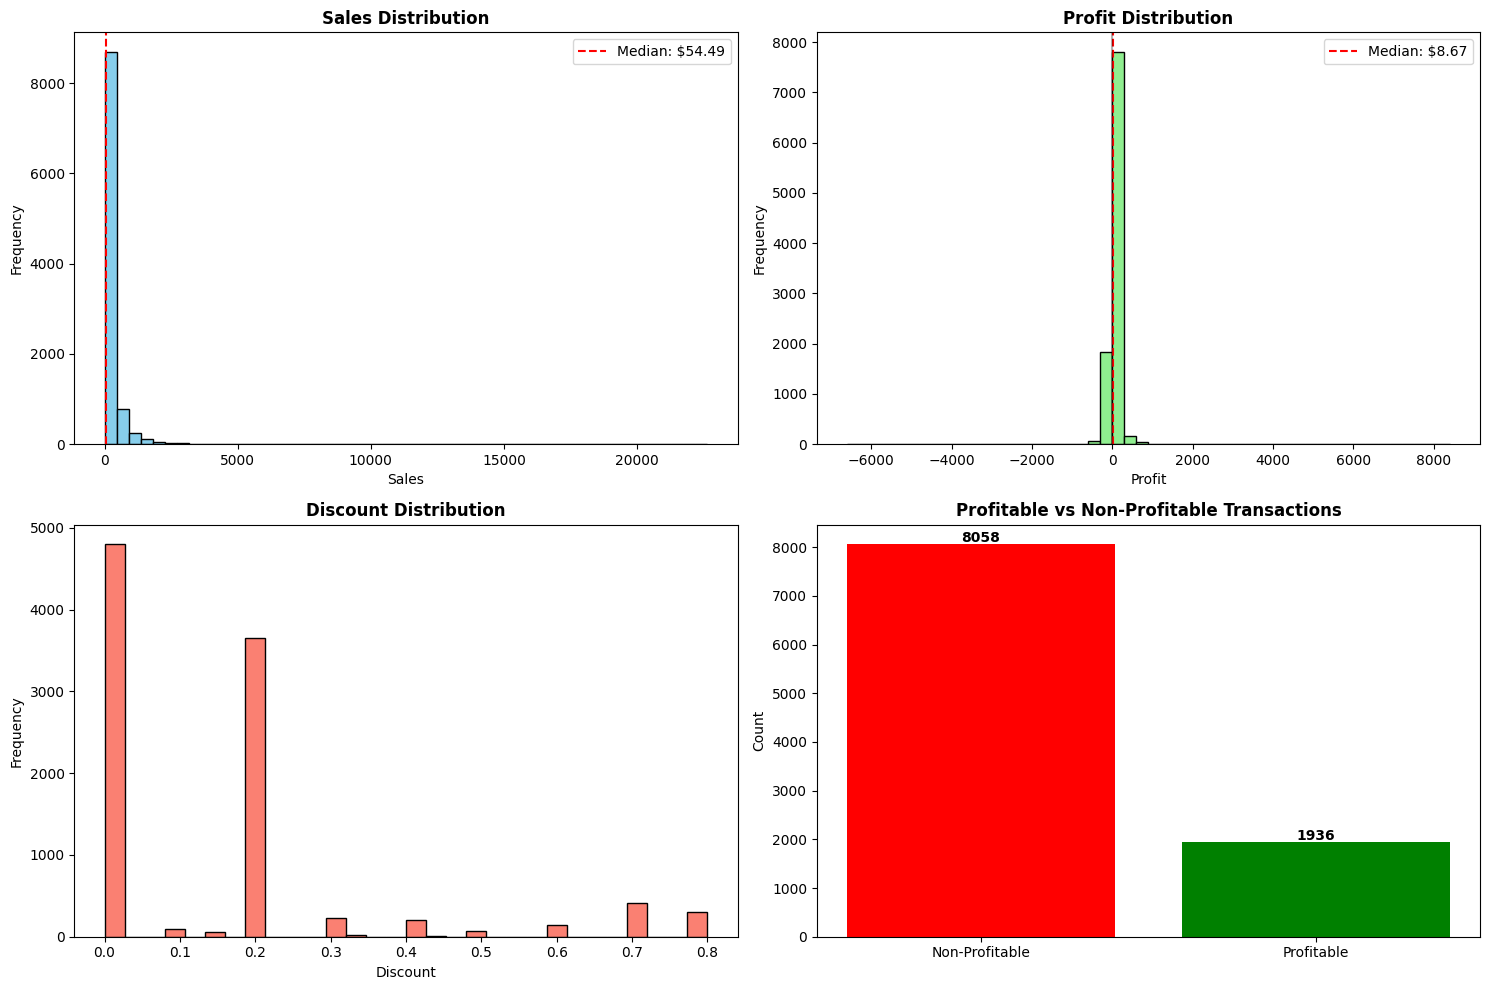

Profitable transactions: 8058 (80.6%)
Non-profitable transactions: 1936 (19.4%)


In [ ]:
# Distribution Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Sales distribution
axes[0, 0].hist(df_superstore_data['Sales'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Sales Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Sales')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df_superstore_data['Sales'].median(), color='red', linestyle='--', label=f'Median: ${df_superstore_data["Sales"].median():.2f}')
axes[0, 0].legend()

# Profit distribution
axes[0, 1].hist(df_superstore_data['Profit'], bins=50, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Profit Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Profit')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(df_superstore_data['Profit'].median(), color='red', linestyle='--', label=f'Median: ${df_superstore_data["Profit"].median():.2f}')
axes[0, 1].axvline(0, color='black', linestyle='-', alpha=0.3)
axes[0, 1].legend()

# Discount distribution
axes[1, 0].hist(df_superstore_data['Discount'], bins=30, color='salmon', edgecolor='black')
axes[1, 0].set_title('Discount Distribution', fontweight='bold')
axes[1, 0].set_xlabel('Discount')
axes[1, 0].set_ylabel('Frequency')

# Profitable vs Non-Profitable
profitable_counts = df_superstore_data['Profitable'].value_counts()
axes[1, 1].bar(['Non-Profitable', 'Profitable'], profitable_counts.values, color=['red', 'green'])
axes[1, 1].set_title('Profitable vs Non-Profitable Transactions', fontweight='bold')
axes[1, 1].set_ylabel('Count')
for i, v in enumerate(profitable_counts.values):
    axes[1, 1].text(i, v + 50, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Profitable transactions: {profitable_counts[1]} ({(profitable_counts[1]/len(df_superstore_data)*100):.1f}%)")
print(f"Non-profitable transactions: {profitable_counts[0]} ({(profitable_counts[0]/len(df_superstore_data)*100):.1f}%)")


### Top 10 Products by Sales and Profit

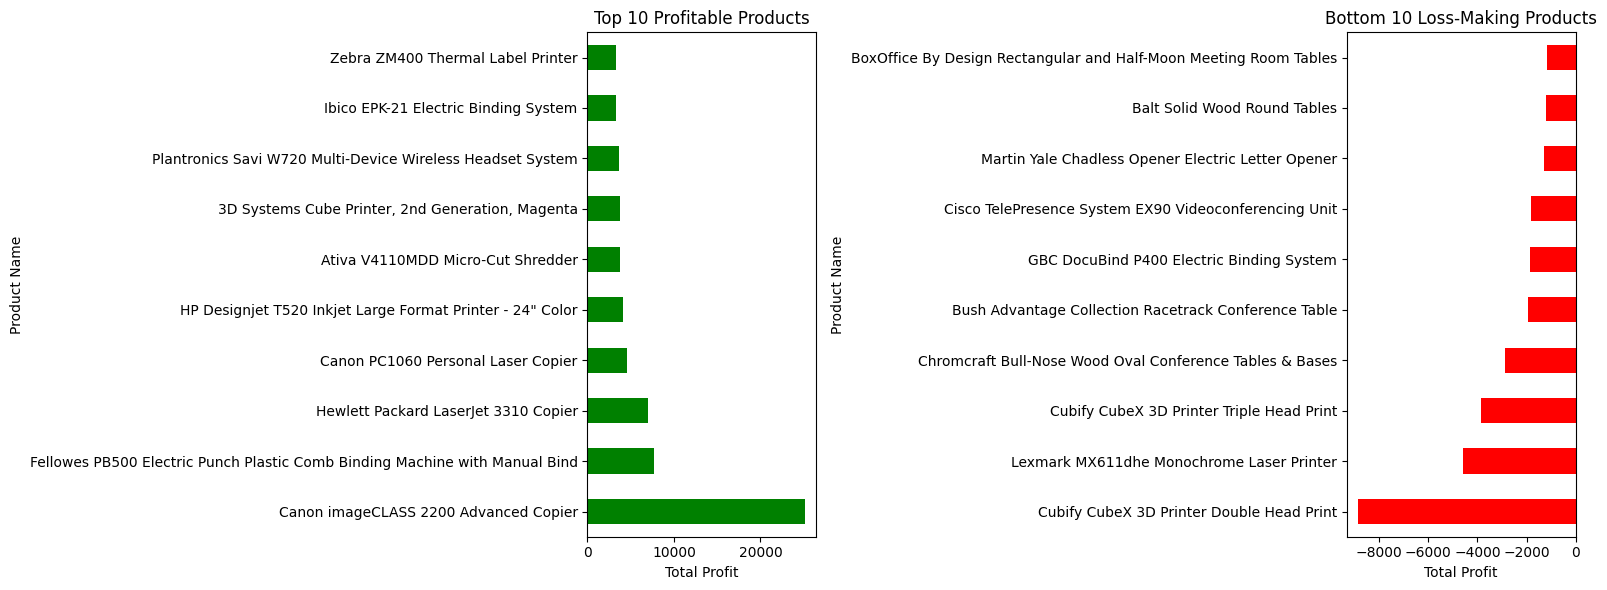

In [ ]:
# Top 10 profitable products
top_products = df_superstore_data.groupby('Product Name')['Profit'].sum().nlargest(10)

# Bottom 10 loss-making products
worst_products = df_superstore_data.groupby('Product Name')['Profit'].sum().nsmallest(10)

# Plot both
fig, axes = plt.subplots(1,2, figsize=(16,6))

top_products.plot(kind='barh', ax=axes[0], color='green')
axes[0].set_title("Top 10 Profitable Products")
axes[0].set_xlabel("Total Profit")

worst_products.plot(kind='barh', ax=axes[1], color='red')
axes[1].set_title("Bottom 10 Loss-Making Products")
axes[1].set_xlabel("Total Profit")

plt.tight_layout()
plt.show()


### Key Performance Indicators (KPIs)

In [ ]:
total_sales = df_superstore_data['Sales'].sum()
total_profit = df_superstore_data['Profit'].sum()
avg_profit_margin = (total_profit / total_sales) * 100

print(f"Total Sales: ${total_sales:,.2f}")
print(f"Total Profit: ${total_profit:,.2f}")
print(f"Average Profit Margin: {avg_profit_margin:.2f}%")

Total Sales: $2,297,200.86
Total Profit: $286,397.02
Average Profit Margin: 12.47%


### Impact of Discounts on Product Performance

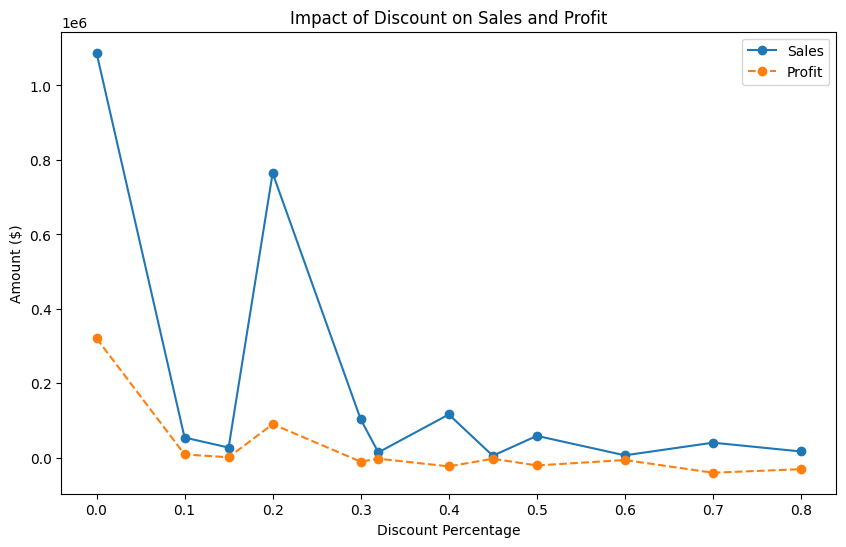

In [ ]:
discount_analysis = df_superstore_data.groupby('Discount').agg({'Sales': 'sum', 'Profit': 'sum'}).reset_index()

plt.figure(figsize=(10, 6))
plt.plot(discount_analysis['Discount'], discount_analysis['Sales'], label='Sales', marker='o')
plt.plot(discount_analysis['Discount'], discount_analysis['Profit'], label='Profit', marker='o', linestyle='--')
plt.xlabel('Discount Percentage')
plt.ylabel('Amount ($)')
plt.title('Impact of Discount on Sales and Profit')
plt.legend()
plt.show()


### Product Performance Across Regions and Segments

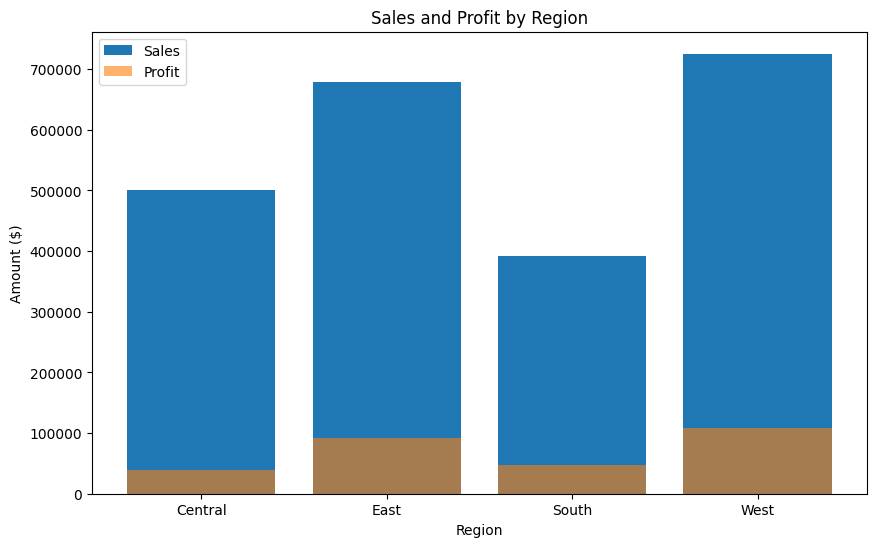

In [ ]:
region_performance = df_superstore_data.groupby('Region').agg({'Sales': 'sum', 'Profit': 'sum'}).reset_index()

plt.figure(figsize=(10, 6))
plt.bar(region_performance['Region'], region_performance['Sales'], label='Sales')
plt.bar(region_performance['Region'], region_performance['Profit'], label='Profit', alpha=0.6)
plt.xlabel('Region')
plt.ylabel('Amount ($)')
plt.title('Sales and Profit by Region')
plt.legend()
plt.show()


## Machine Learning Model Development


### Model 1: Profit Prediction (Regression)


In [ ]:
#### Data Preparation for Regression Models
print("=" * 80)
print("REGRESSION MODEL: DATA PREPARATION")
print("=" * 80)

# Select features for regression
features = ['Sales', 'Discount', 'Quantity', 'Category', 'Segment', 'Region', 'Ship Mode']
target = 'Profit'

# Prepare data
df_reg = df_superstore_data[features + [target]].dropna()
df_reg = df_reg[df_reg['Profit'] > -1]  # Remove extreme outliers

# Log transformation for better model performance
df_reg['Sales'] = np.log1p(df_reg['Sales'])
df_reg['Profit'] = np.log1p(df_reg['Profit'])

# One-hot encoding
df_encoded = pd.get_dummies(df_reg, columns=['Category', 'Segment', 'Region', 'Ship Mode'], drop_first=True)

# Separate features and target
X = df_encoded.drop(columns=['Profit'])
y = df_encoded['Profit']

# Train-test split
TEST_SIZE = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

print(f"\n✓ Features: {features}")
print(f"✓ Target: {target}")
print(f"✓ Log transformation applied: log1p(Sales), log1p(Profit)")
print(f"✓ Encoding: One-hot encoding (drop_first=True)")
print(f"\n✓ Train-Test Split:")
print(f"  - Test size: {TEST_SIZE * 100}%")
print(f"  - Random state: {RANDOM_STATE}")
print(f"  - Training samples: {len(X_train)}")
print(f"  - Testing samples: {len(X_test)}")
print(f"  - Total features after encoding: {X.shape[1]}")
print("=" * 80)


REGRESSION MODEL: DATA PREPARATION

✓ Features: ['Sales', 'Discount', 'Quantity', 'Category', 'Segment', 'Region', 'Ship Mode']
✓ Target: Profit
✓ Log transformation applied: log1p(Sales), log1p(Profit)
✓ Encoding: One-hot encoding (drop_first=True)

✓ Train-Test Split:
  - Test size: 20.0%
  - Random state: 42
  - Training samples: 6526
  - Testing samples: 1632
  - Total features after encoding: 13


In [ ]:
#### Baseline Model (Regression)
print("BASELINE MODEL: Mean Predictor")
print("=" * 80)

# Create baseline model that predicts mean
baseline_reg = DummyRegressor(strategy='mean')
baseline_reg.fit(X_train, y_train)
y_pred_baseline = baseline_reg.predict(X_test)

# Convert back from log space
y_test_real = np.expm1(y_test)
y_pred_baseline_real = np.expm1(y_pred_baseline)

# Calculate metrics
baseline_mae = mean_absolute_error(y_test_real, y_pred_baseline_real)
baseline_mse = mean_squared_error(y_test_real, y_pred_baseline_real)
baseline_rmse = np.sqrt(baseline_mse)
baseline_r2 = r2_score(y_test_real, y_pred_baseline_real)

print(f"\nBaseline Model Performance (predicts mean profit for all transactions):")
print(f"  MAE:  ${baseline_mae:.2f}")
print(f"  RMSE: ${baseline_rmse:.2f}")
print(f"  R²:   {baseline_r2:.3f}")
print(f"\nThis baseline will be used to compare advanced models.")
print("=" * 80)


BASELINE MODEL: Mean Predictor

Baseline Model Performance (predicts mean profit for all transactions):
  MAE:  $54.36
  RMSE: $283.26
  R²:   -0.025

This baseline will be used to compare advanced models.


In [ ]:
#### Advanced Regression Models with Cross-Validation
print("ADVANCED REGRESSION MODELS WITH 5-FOLD CROSS-VALIDATION")
print("=" * 80)

# Define models
models_reg = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=RANDOM_STATE)
}

# Store results
regression_results = []

# 5-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

for name, model in models_reg.items():
    print(f"\nTraining {name}...")

    # Cross-validation scores (on log-transformed data)
    cv_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')

    # Train on full training set
    model.fit(X_train, y_train)

    # Predictions
    y_pred_log = model.predict(X_test)
    y_pred_log_clipped = np.clip(y_pred_log, a_min=None, a_max=20)
    y_test_log_clipped = np.clip(y_test, a_min=None, a_max=20)

    # Convert back to original scale
    y_pred_real = np.expm1(y_pred_log_clipped)
    y_test_real = np.expm1(y_test_log_clipped)

    # Calculate metrics
    mae = mean_absolute_error(y_test_real, y_pred_real)
    # rmse = mean_squared_error(y_test_real, y_pred_real, squared=False)
    mse = mean_squared_error(y_test_real, y_pred_real)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_real, y_pred_real)

    regression_results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'CV R² Mean': cv_scores.mean(),
        'CV R² Std': cv_scores.std()
    })

    print(f"  ✓ Test MAE:  ${mae:.2f}")
    print(f"  ✓ Test RMSE: ${rmse:.2f}")
    print(f"  ✓ Test R²:   {r2:.3f}")
    print(f"  ✓ CV R² (mean ± std): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

print("\n" + "=" * 80)


ADVANCED REGRESSION MODELS WITH 5-FOLD CROSS-VALIDATION

Training Linear Regression...
  ✓ Test MAE:  $32.06
  ✓ Test RMSE: $214.53
  ✓ Test R²:   0.412
  ✓ CV R² (mean ± std): 0.776 ± 0.021

Training Random Forest...
  ✓ Test MAE:  $25.63
  ✓ Test RMSE: $141.12
  ✓ Test R²:   0.746
  ✓ CV R² (mean ± std): 0.807 ± 0.015

Training Gradient Boosting...
  ✓ Test MAE:  $26.75
  ✓ Test RMSE: $141.47
  ✓ Test R²:   0.744
  ✓ CV R² (mean ± std): 0.808 ± 0.019



In [ ]:
#### Comprehensive Regression Model Comparison
print("REGRESSION MODELS PERFORMANCE COMPARISON")
print("=" * 80)

# Add baseline to results
regression_results.insert(0, {
    'Model': 'Baseline (Mean)',
    'MAE': baseline_mae,
    'RMSE': baseline_rmse,
    'R²': baseline_r2,
    'CV R² Mean': baseline_r2,
    'CV R² Std': 0.0
})

# Create DataFrame
results_df = pd.DataFrame(regression_results)

# Format and display
print("\n" + results_df.to_string(index=False))

# Find best model
best_model_idx = results_df['R²'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']

print(f"\n{'=' * 80}")
print(f"BEST MODEL: {best_model_name}")
print(f"  - R²: {results_df.loc[best_model_idx, 'R²']:.3f}")
print(f"  - MAE: ${results_df.loc[best_model_idx, 'MAE']:.2f}")
print(f"  - RMSE: ${results_df.loc[best_model_idx, 'RMSE']:.2f}")

# Calculate improvement over baseline
improvement = ((results_df.loc[best_model_idx, 'R²'] - baseline_r2) / abs(baseline_r2)) * 100
print(f"  - Improvement over baseline: {improvement:.1f}%")
print("=" * 80)


REGRESSION MODELS PERFORMANCE COMPARISON

            Model       MAE       RMSE        R²  CV R² Mean  CV R² Std
  Baseline (Mean) 54.363525 283.262769 -0.025177   -0.025177   0.000000
Linear Regression 32.056438 214.526675  0.411993    0.776248   0.020697
    Random Forest 25.625581 141.121038  0.745549    0.807111   0.014923
Gradient Boosting 26.746223 141.468176  0.744296    0.807685   0.018883

BEST MODEL: Random Forest
  - R²: 0.746
  - MAE: $25.63
  - RMSE: $141.12
  - Improvement over baseline: 3061.2%


In [ ]:
#### Hyperparameter Tuning (Random Forest)
print("HYPERPARAMETER TUNING: Random Forest Regressor")
print("=" * 80)

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

print("Parameter Grid:")
for param, values in param_grid.items():
    print(f"  - {param}: {values}")

# Grid search with cross-validation
rf_model = RandomForestRegressor(random_state=RANDOM_STATE)
grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=0)

print("\nPerforming Grid Search (3-fold CV)...")
grid_search.fit(X_train, y_train)

print(f"\n✓ Best Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  - {param}: {value}")

# Evaluate tuned model
y_pred_tuned_log = grid_search.predict(X_test)
y_pred_tuned_log_clipped = np.clip(y_pred_tuned_log, a_min=None, a_max=20)
y_pred_tuned_real = np.expm1(y_pred_tuned_log_clipped)

tuned_mae = mean_absolute_error(y_test_real, y_pred_tuned_real)
# tuned_rmse = mean_squared_error(y_test_real, y_pred_tuned_real, squared=False)
tuned_mse = mean_squared_error(y_test_real, y_pred_tuned_real)
tuned_rmse = np.sqrt(tuned_mse)
tuned_r2 = r2_score(y_test_real, y_pred_tuned_real)

print(f"\n✓ Tuned Model Performance:")
print(f"  - MAE:  ${tuned_mae:.2f}")
print(f"  - RMSE: ${tuned_rmse:.2f}")
print(f"  - R²:   {tuned_r2:.3f}")
print(f"  - Best CV Score: {grid_search.best_score_:.3f}")
print("=" * 80)


HYPERPARAMETER TUNING: Random Forest Regressor
Parameter Grid:
  - n_estimators: [50, 100, 200]
  - max_depth: [10, 20, None]
  - min_samples_split: [2, 5]
  - min_samples_leaf: [1, 2]

Performing Grid Search (3-fold CV)...

✓ Best Parameters:
  - max_depth: 10
  - min_samples_leaf: 2
  - min_samples_split: 5
  - n_estimators: 100

✓ Tuned Model Performance:
  - MAE:  $26.84
  - RMSE: $148.78
  - R²:   0.717
  - Best CV Score: 0.808


LEARNING CURVES: Detecting Overfitting/Underfitting


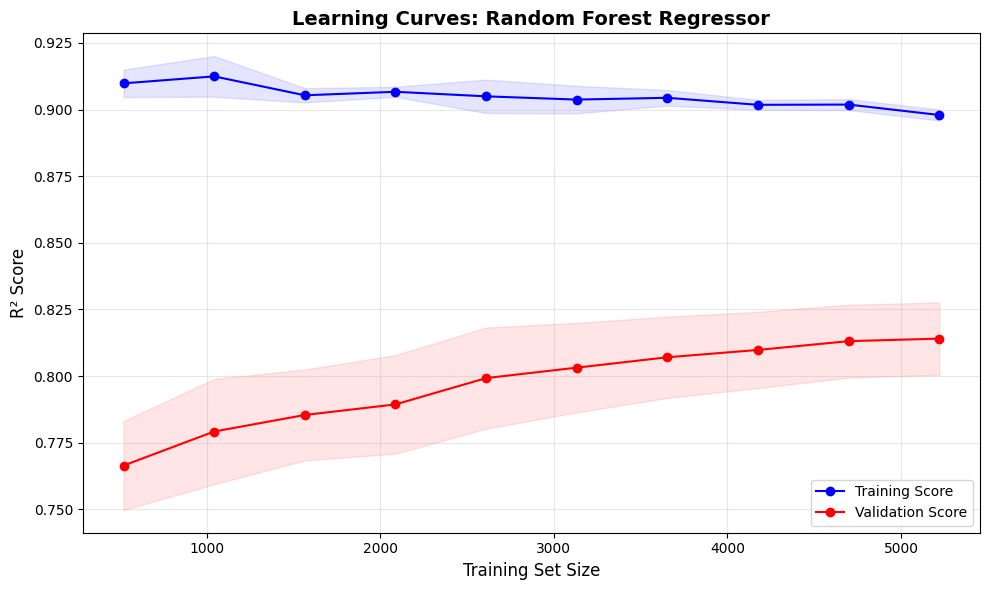


✓ Final Training R²: 0.898
✓ Final Validation R²: 0.814
✓ Gap (Training - Validation): 0.084
✓ Model shows good generalization (low overfitting)


In [ ]:
#### Learning Curves - Overfitting/Underfitting Analysis
print("LEARNING CURVES: Detecting Overfitting/Underfitting")
print("=" * 80)

# Use the best model from grid search
best_rf_model = grid_search.best_estimator_

# Calculate learning curves
train_sizes, train_scores, val_scores = learning_curve(
    best_rf_model, X_train, y_train, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='r2', n_jobs=-1, random_state=RANDOM_STATE
)

# Calculate mean and std
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_mean = val_scores.mean(axis=1)
val_scores_std = val_scores.std(axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training Score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.plot(train_sizes, val_scores_mean, 'o-', color='red', label='Validation Score')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color='red')

plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title('Learning Curves: Random Forest Regressor', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Diagnosis
gap = train_scores_mean[-1] - val_scores_mean[-1]
print(f"\n✓ Final Training R²: {train_scores_mean[-1]:.3f}")
print(f"✓ Final Validation R²: {val_scores_mean[-1]:.3f}")
print(f"✓ Gap (Training - Validation): {gap:.3f}")

if gap < 0.1:
    print("✓ Model shows good generalization (low overfitting)")
elif gap < 0.2:
    print("⚠ Model shows moderate overfitting")
else:
    print("✗ Model shows significant overfitting")

print("=" * 80)


RESIDUAL ANALYSIS


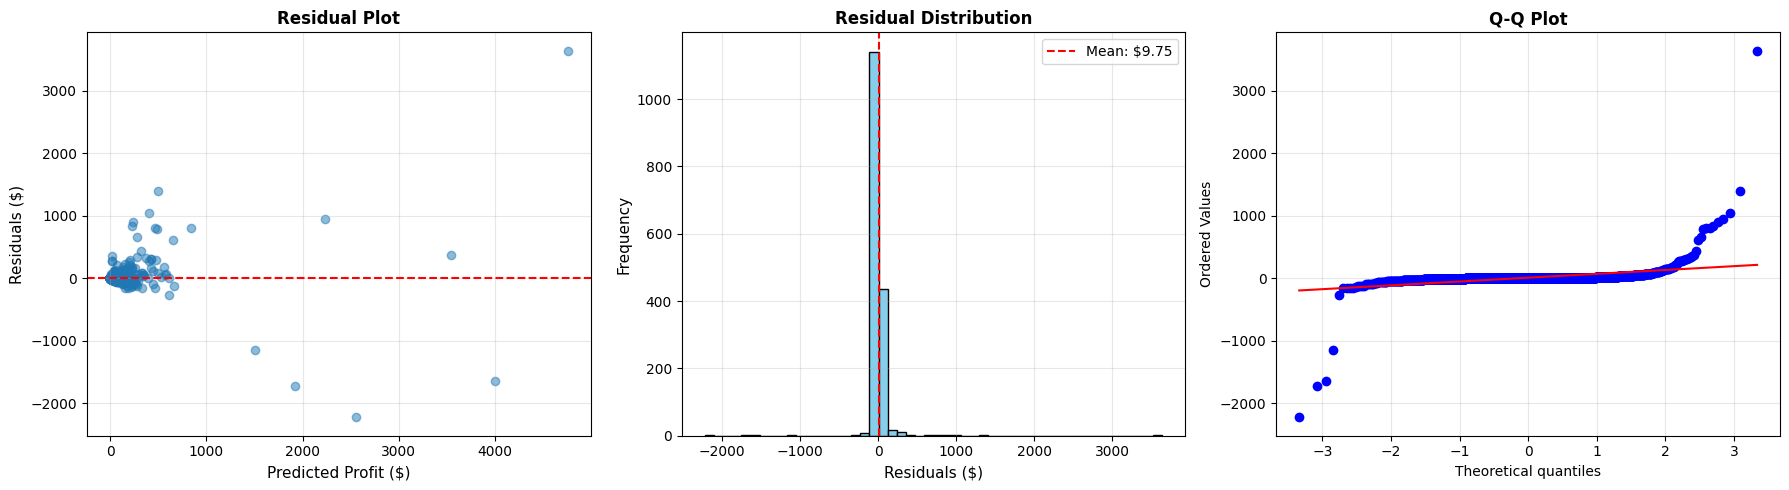


✓ Residual Statistics:
  - Mean: $9.75 (should be close to 0)
  - Std Dev: $148.51
  - Median: $0.71
  - Min: $-2227.09
  - Max: $3643.81

✓ Largest Prediction Errors (Top 5):
   Actual   Predicted       Error
8399.9760 4756.168876 3643.807124
 327.5060 2554.591095 2227.085095
 196.5036 1920.084371 1723.580771
2365.9818 4005.044925 1639.063125
1906.4850  502.896652 1403.588348


In [ ]:
#### Residual Analysis - Error Analysis
print("RESIDUAL ANALYSIS")
print("=" * 80)

# Calculate residuals
residuals = y_test_real - y_pred_tuned_real

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Residual Plot
axes[0].scatter(y_pred_tuned_real, residuals, alpha=0.5)
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_xlabel('Predicted Profit ($)', fontsize=11)
axes[0].set_ylabel('Residuals ($)', fontsize=11)
axes[0].set_title('Residual Plot', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# 2. Residual Distribution
axes[1].hist(residuals, bins=50, edgecolor='black', color='skyblue')
axes[1].axvline(residuals.mean(), color='red', linestyle='--', label=f'Mean: ${residuals.mean():.2f}')
axes[1].set_xlabel('Residuals ($)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Residual Distribution', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Q-Q Plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot', fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical summary
print(f"\n✓ Residual Statistics:")
print(f"  - Mean: ${residuals.mean():.2f} (should be close to 0)")
print(f"  - Std Dev: ${residuals.std():.2f}")
print(f"  - Median: ${residuals.median():.2f}")
print(f"  - Min: ${residuals.min():.2f}")
print(f"  - Max: ${residuals.max():.2f}")

# Largest errors
print(f"\n✓ Largest Prediction Errors (Top 5):")
error_df = pd.DataFrame({
    'Actual': y_test_real,
    'Predicted': y_pred_tuned_real,
    'Error': abs(residuals)
})
print(error_df.nlargest(5, 'Error').to_string(index=False))
print("=" * 80)
